In [85]:
import tensorflow as tf
import time

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [86]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [87]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


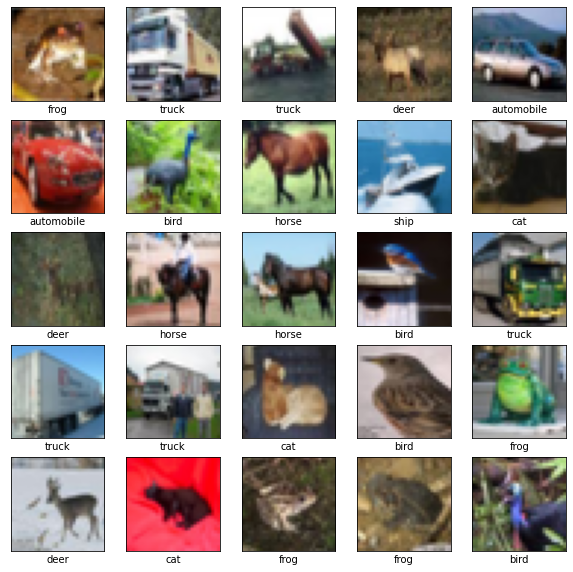

In [88]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# Big Data HW1 : Step (1) Creating Dataset Variations

Downscaling Images from 32*32 to 16*16 pixels

### Making change for outlier as well as model complexity

In [89]:
for idx,train_label in enumerate(train_labels):
    if train_label not in [0, 1]:
        train_labels[idx] = 2
        
print(train_labels)

[[2]
 [2]
 [2]
 ...
 [2]
 [1]
 [1]]


In [108]:
for idx,test_label in enumerate(test_labels):
    if test_label not in [0, 1]:
        test_labels[idx] = 2

In [109]:
from PIL import Image
import numpy as np

train_images_16_16 = np.empty([int(train_images.shape[0]), int(train_images.shape[1]/2), int(train_images.shape[2]/2), int(train_images.shape[3])])
for idx,train_image in enumerate(train_images):
    im = Image.fromarray((train_image*255).astype(np.uint8))
    im_resize = im.resize((im.width//2, im.height//2))
    im_downscale = np.array(im_resize.getdata()).reshape((im_resize.size[0],im_resize.size[1],3))
    train_images_16_16[idx] = im_downscale

In [110]:
test_images_16_16 = np.empty([int(test_images.shape[0]), int(test_images.shape[1]/2), int(test_images.shape[2]/2), int(test_images.shape[3])])
for idx,test_image in enumerate(test_images):
    im = Image.fromarray((test_image*255).astype(np.uint8))
    im_resize = im.resize((im.width//2, im.height//2))
    im_downscale = np.array(im_resize.getdata()).reshape((im_resize.size[0],im_resize.size[1],3))
    test_images_16_16[idx] = im_downscale

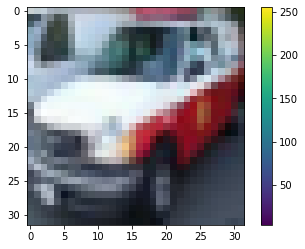

In [111]:
#ORIGINAL IMAGE
plt.figure()
plt.imshow(Image.fromarray((train_images[60]*255).astype(np.uint8)))
plt.colorbar()
plt.grid(False)
plt.show()

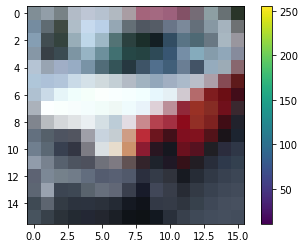

In [112]:
#REDUCED RESOLUTION IMAGE
plt.figure()
plt.imshow(Image.fromarray((train_images_16_16[60]).astype(np.uint8)))
plt.colorbar()
plt.grid(False)
plt.show()

In [113]:
train_images_16_16 = train_images_16_16/255
test_images_16_16 = test_images_16_16/255

### Verify lower resolution dataset

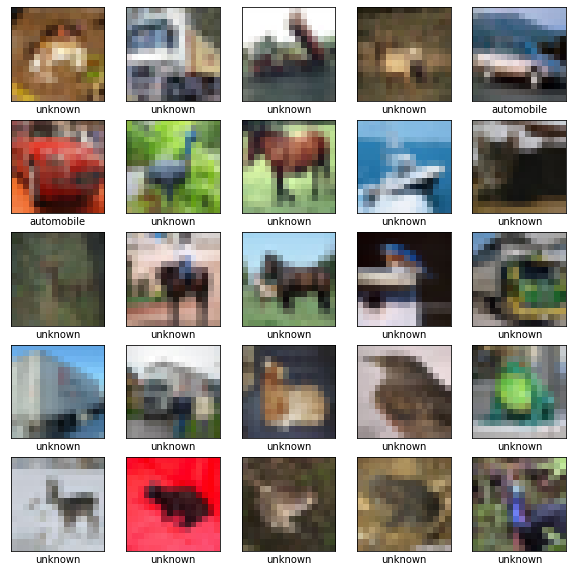

In [114]:
class_names = ['airplane', 'automobile', 'unknown', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_16_16[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Utility functions for modular coding

In [115]:
def create_model(pixel, max_pool_parameter):
    model = models.Sequential()
    model.add(layers.Conv2D(pixel, (3, 3), activation='relu', input_shape=(pixel, pixel, 3)))
    model.add(layers.MaxPooling2D((max_pool_parameter, max_pool_parameter)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((max_pool_parameter, max_pool_parameter)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    return model

In [116]:
def train_model(model, model_name, train_data, train_label, test_data, test_label):
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    t0 = time.time()
    history = model.fit(train_data, train_label, epochs=10, validation_data=(test_data, test_label))
    t1 = time.time()
    print("Total training time to train ", model_name, t1-t0)
    model.save(model_name+'.h5')
    return history, model

In [117]:
def train_model_only_CPU(model, model_name, train_data, train_label, test_data, test_label):
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    t0 = time.time()
    with tf.device('/CPU:0'):
        history = model.fit(train_data, train_label, epochs=10, validation_data=(test_data, test_label))
    t1 = time.time()
    print("Total training time to train ", model_name, t1-t0)
    model.save(model_name+'.h5')
    return history, model

In [118]:
def evaluate_model(fig_name, model, history, test_data, test_model):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.savefig(fig_name+'.png')

    test_loss, test_acc = model.evaluate(test_data, test_model, verbose=2)
    print('Validation accuracy ', test_acc)

# Training with CPU + GPU

### Compile, train and calculate accuracy of model for 32*32 full size dataset

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1560/1563 [============================>.] - ETA: 0s - loss: 0.5520 - accuracy: 0.8155WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x173c810d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

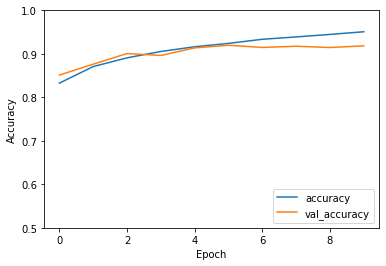

In [119]:
model1 = create_model(32, 2)
history1, model1 = train_model(model1, '32_32_complete', train_images, train_labels, test_images, test_labels)
evaluate_model('32_32_complete', model1, history1, test_images, test_labels)

### Compile, train and calculate accuracy of model for 32*32 reduced size dataset

In [120]:
#Sampling images from train dataset for reduced dataset model evaluation
validation_images = train_images[49000:]
validation_labels = train_labels[49000:]

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
311/313 [============================>.] - ETA: 0s - loss: 0.7121 - accuracy: 0.7947WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2d81b8a60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

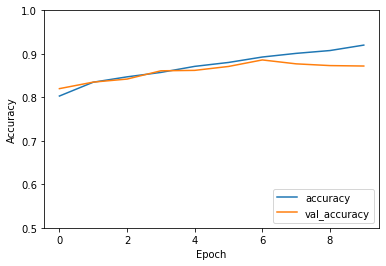

In [121]:
#Training on test dataset as it is smaller in size. Have sliced 1000 rows from the training dataset for validation here. 
model2 = create_model(32, 2)
history2, model2 = train_model(model2, '32_32_smaller_dataset', test_images, test_labels, validation_images, validation_labels)
evaluate_model('32_32_smaller_dataset', model2, history2, validation_images, validation_labels)

### Compile, train and evaluate model for 16*16 resolution images on full size dataset

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1560/1563 [============================>.] - ETA: 0s - loss: 0.5128 - accuracy: 0.8219WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2af0bf670> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

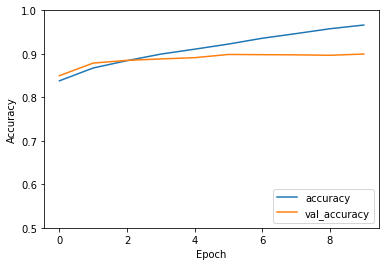

In [122]:
model3 = create_model(16, 1)
history3, model3 = train_model(model3, '16_16_complete', train_images_16_16, train_labels, test_images_16_16, test_labels)
evaluate_model('16_16_complete', model3, history3, test_images_16_16, test_labels)

### Compile, train and evaluate model for 16*16 resolution images on half size dataset

In [123]:
validation_16_16_data = train_images_16_16[49000:]
validation_16_16_labels = train_labels[49000:]

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
307/313 [============================>.] - ETA: 0s - loss: 0.7208 - accuracy: 0.7856WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b89be4c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

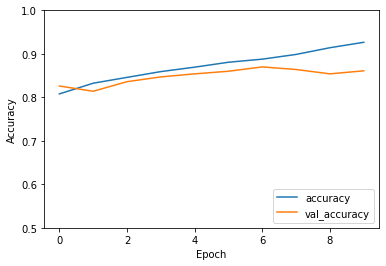

In [124]:
model4 = create_model(16, 1)
history4, model4 = train_model(model4, '16_16_smaller_dataset', test_images_16_16, test_labels, validation_16_16_data, validation_16_16_labels)
evaluate_model('16_16_smaller_datatset', model4, history4, validation_16_16_data, validation_16_16_labels)

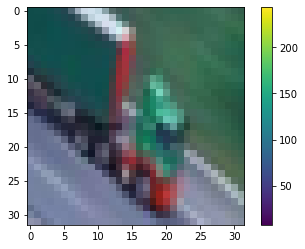

unknown


In [126]:
plt.figure()
plt.imshow(Image.fromarray((train_images[50]*255).astype(np.uint8)))
plt.colorbar()
plt.grid(False)
plt.show()

image = train_images[50]
idx = np.argmax(model1.predict(image[np.newaxis,:]))
print(class_names[idx])

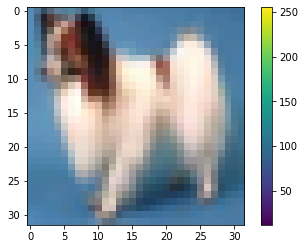

unknown


In [131]:
plt.figure()
plt.imshow(Image.fromarray((train_images[4000]*255).astype(np.uint8)))
plt.colorbar()
plt.grid(False)
plt.show()

image = train_images[4000]
idx = np.argmax(model1.predict(image[np.newaxis,:]))
print(class_names[idx])

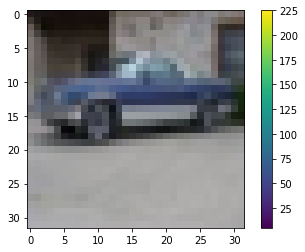

automobile


In [132]:
plt.figure()
plt.imshow(Image.fromarray((train_images[10000]*255).astype(np.uint8)))
plt.colorbar()
plt.grid(False)
plt.show()

image = train_images[10000]
idx = np.argmax(model1.predict(image[np.newaxis,:]))
print(class_names[idx])